# Load Sentinel-3 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-3 data from the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../../README.md).

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
import itertools

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

CPU times: user 3.14 s, sys: 248 ms, total: 3.39 s
Wall time: 1.56 s


In [2]:
xr.set_options(display_expand_attrs=False)

Next store the credentials in a dictionary. 

In [3]:
credentials = dict(
    key="O0M0CUQIDQO9TDZ4D8NR",
    secret="qPUyXs9G6j8on6MY5KPhQNHuA5uZTqxEscrbBCGx"
)

First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that key and secret of the S3 access are required.

In [4]:
%%time
store_params = get_data_store_params_schema("stac-cdse")
store_params

CPU times: user 556 ms, sys: 69 ms, total: 624 ms
Wall time: 624 ms


To initialize the CDSE STAC data store, execute the following cell.

In [5]:
%%time
store = new_data_store("stac-cdse", **credentials)

CPU times: user 10.4 ms, sys: 2.23 ms, total: 12.6 ms
Wall time: 338 ms


Below, the parameters for the `open_data` method can be viewed.

In [6]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 37 μs, sys: 3 μs, total: 40 μs
Wall time: 43.2 μs


If we specify the data ID, we obtain more precise parameters for opening and accessing that specific dataset.

In [7]:
data_id = (
    "collections/sentinel-3-syn-2-syn-ntc/items/S3B_SY_2_SYN____20250706T233058_"
    "20250706T233358_20250708T043306_0179_108_258_3420_ESA_O_NT_002"
)
store.get_open_data_params_schema(data_id=data_id)

We can now open the data set associated with the data ID. Note that first we do not apply any rectification. Thus the data is shown on the irregular native grid. 

In [8]:
%%time
ds = store.open_data(data_id, apply_rectification=False)
ds

CPU times: user 9.01 s, sys: 3.85 s, total: 12.9 s
Wall time: 1min 5s


<xarray.Dataset> Size: 5GB
Dimensions:       (rows: 4091, columns: 4865)
Coordinates:
    lon           (rows, columns) float32 80MB dask.array<chunksize=(819, 973), meta=np.ndarray>
    lat           (rows, columns) float32 80MB dask.array<chunksize=(819, 973), meta=np.ndarray>
Dimensions without coordinates: rows, columns
Data variables: (12/61)
    CLOUD_flags   (rows, columns) uint8 20MB dask.array<chunksize=(1364, 1622), meta=np.ndarray>
    OLC_flags     (rows, columns) uint16 40MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SLN_flags     (rows, columns) uint32 80MB dask.array<chunksize=(819, 973), meta=np.ndarray>
    SLO_flags     (rows, columns) uint32 80MB dask.array<chunksize=(819, 973), meta=np.ndarray>
    SYN_flags     (rows, columns) uint16 40MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    AMIN          (rows, columns) float32 80MB dask.array<chunksize=(1364, 1622), meta=np.ndarray>
    ...            ...
    SDR_Oa17      (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa17_err  (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18      (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18_err  (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21      (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21_err  (rows, columns) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
Attributes: (15)

CPU times: user 10 s, sys: 3.7 s, total: 13.7 s
Wall time: 1min 6s


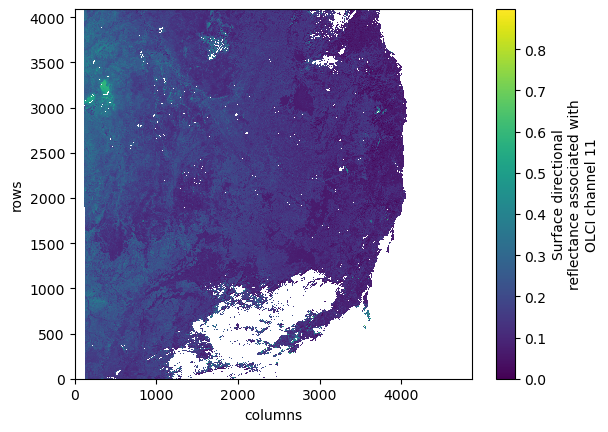

In [9]:
%%time
ds.SDR_Oa11.plot()

In the next step we show the dataset on a regular grid, where the [xcube's rectification algorithm](https://xcube.readthedocs.io/en/latest/rectify.html) is applied. Note that showning the data on a regular grid is the default. 

In [10]:
%%time
ds = store.open_data(data_id)
ds

CPU times: user 31.3 s, sys: 7.59 s, total: 38.9 s
Wall time: 2min 50s


<xarray.Dataset> Size: 6GB
Dimensions:       (lat: 4493, lon: 5351, bnds: 2)
Coordinates:
  * lat           (lat) float64 36kB -21.05 -21.05 -21.06 ... -34.52 -34.53
  * lon           (lon) float64 43kB 140.9 140.9 140.9 ... 157.0 157.0 157.0
    lon_bnds      (lon, bnds) float64 86kB 140.9 140.9 140.9 ... 157.0 157.0
    lat_bnds      (lat, bnds) float64 72kB -21.05 -21.05 ... -34.53 -34.53
Dimensions without coordinates: bnds
Data variables: (12/61)
    CLOUD_flags   (lat, lon) uint8 24MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    OLC_flags     (lat, lon) uint16 48MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SLN_flags     (lat, lon) uint32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SLO_flags     (lat, lon) uint32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SYN_flags     (lat, lon) uint16 48MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    AMIN          (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    ...            ...
    SDR_Oa17      (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa17_err  (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18      (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18_err  (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21      (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21_err  (lat, lon) float32 96MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
Attributes: (15)

CPU times: user 15.1 s, sys: 1.28 s, total: 16.4 s
Wall time: 7.98 s


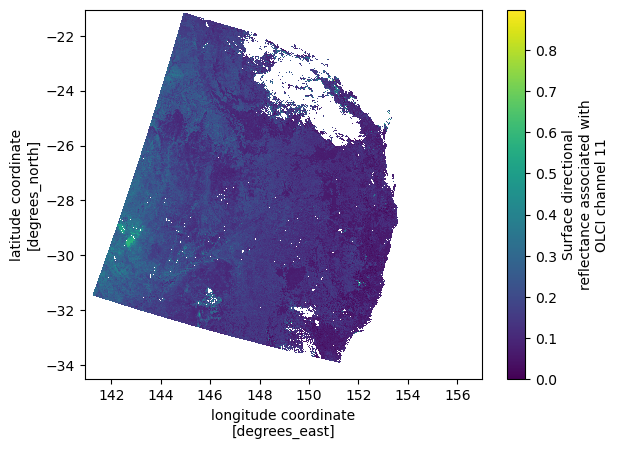

In [11]:
%%time
ds.SDR_Oa11.plot()